In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns


In [2]:
#reading Building1.csv

electricity_data = pd.read_csv("citylearn_challenge_2023_phase_1/Building_1.csv")
print(electricity_data)

     month  hour  day_type  daylight_savings_status  \
0        6     1         5                        0   
1        6     2         5                        0   
2        6     3         5                        0   
3        6     4         5                        0   
4        6     5         5                        0   
..     ...   ...       ...                      ...   
715      6    20         6                        0   
716      6    21         6                        0   
717      6    22         6                        0   
718      6    23         6                        0   
719      6    24         6                        0   

     indoor_dry_bulb_temperature  average_unmet_cooling_setpoint_difference  \
0                      23.098652                                  -0.123570   
1                      22.234743                                   0.012520   
2                      22.223060                                   0.000838   
3                      

In [3]:
carbon_data = pd.read_csv("citylearn_challenge_2023_phase_1/carbon_intensity.csv")
print(carbon_data)

     carbon_intensity
0            0.402488
1            0.382625
2            0.369458
3            0.367017
4            0.374040
..                ...
715          0.465811
716          0.470324
717          0.462414
718          0.448648
719          0.428057

[720 rows x 1 columns]


In [4]:
pricing_data = pd.read_csv("citylearn_challenge_2023_phase_1/pricing.csv")
print(pricing_data)

     electricity_pricing  electricity_pricing_predicted_6h  \
0                0.02893                           0.02893   
1                0.02893                           0.02915   
2                0.02893                           0.02915   
3                0.02893                           0.02915   
4                0.02893                           0.02915   
..                   ...                               ...   
715              0.02893                           0.02893   
716              0.02893                           0.02893   
717              0.02893                           0.02893   
718              0.02893                           0.02893   
719              0.02893                           0.02893   

     electricity_pricing_predicted_12h  electricity_pricing_predicted_24h  
0                              0.02915                            0.02893  
1                              0.02915                            0.02893  
2                          

In [5]:
weather_data = pd.read_csv("citylearn_challenge_2023_phase_1/weather.csv")
print(weather_data)

     outdoor_dry_bulb_temperature  outdoor_relative_humidity  \
0                           24.66                      77.56   
1                           24.07                      85.12   
2                           23.90                      89.62   
3                           23.87                      91.88   
4                           23.83                      93.06   
..                            ...                        ...   
715                         31.98                      43.75   
716                         29.92                      51.62   
717                         28.48                      59.12   
718                         27.27                      66.56   
719                         26.26                      73.75   

     diffuse_solar_irradiance  direct_solar_irradiance  \
0                        0.00                     0.00   
1                        0.00                     0.00   
2                        0.00                     0.00   

In [6]:
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)
print(df)

     month  hour  day_type  daylight_savings_status  \
0        6     1         5                        0   
1        6     2         5                        0   
2        6     3         5                        0   
3        6     4         5                        0   
4        6     5         5                        0   
..     ...   ...       ...                      ...   
715      6    20         6                        0   
716      6    21         6                        0   
717      6    22         6                        0   
718      6    23         6                        0   
719      6    24         6                        0   

     indoor_dry_bulb_temperature  average_unmet_cooling_setpoint_difference  \
0                      23.098652                                  -0.123570   
1                      22.234743                                   0.012520   
2                      22.223060                                   0.000838   
3                      

In [7]:
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
def NRMSE(real, pred):
    return sqrt(mean_squared_error(real, pred)/(real.max() - real.min()))

In [9]:
# Funzione per calcolare NRMSE per una singola variabile con finestra temporale
#per facilitarmi ho cercato di calcolare lo ScoreForecast come se avessi una sola variabile
#poi come si vede in fondo al file faccio una classica media sugli nrmse calcolati in questo modo

def NRMSE_window_single_variable(real, pred, w):
    num_timesteps = len(real)  # Total number of time steps, quindi quello che è indicato con n
    nrmse_windows = []  # Lista per raccogliere gli NRMSE di ciascuna finestra, quindi dalla formula la sommatoria sotto radice
    
    # Itero su ogni finestra temporale
    for t in range(num_timesteps - w + 1):
        #qui cerco di trovare quello che in teoria definisce ft,τv: Forecast of variable v for time step t+τ, made at time t;
        
        real_window = real[t:t+w]
        pred_window = pred[t:t+w]
        
        # Calcolo l'NRMSE tra i valori reali e predetti della finestra e lo aggiungo alla lista
        nrmse_windows.append(NRMSE(real_window, pred_window))
    
    # Restituisco infine la media degli NRMSE per tutte le finestre temporali
    return np.mean(nrmse_windows)

In [10]:
def transformer_encoder (inputs, head_size, num_heads, ff_dim, dropout = 0):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dropout(dropout)(ffn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)

    return LayerNormalization(epsilon=1e-6)(ffn_output + out1)

In [11]:
# Descriptive statistics summary
df.describe()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
count,720.0,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,6.0,12.500000,4.100000,0.0,24.024244,0.003642,57.808783,0.625618,0.213675,3.333438,...,29.620327,63.424809,62.786474,61.793372,90.000166,92.607278,91.938938,269.654399,270.472846,272.939691
std,0.0,6.926999,1.973679,0.0,1.538245,0.042871,4.707318,0.810932,0.469465,1.827450,...,4.958327,23.154273,23.444021,24.038353,107.451266,113.491246,115.477304,308.867793,313.529048,320.500605
min,6.0,1.000000,1.000000,0.0,19.999914,-0.238674,46.463528,0.319633,0.000000,0.000000,...,20.947014,19.430300,18.265532,16.665543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.0,6.750000,2.000000,0.0,22.332079,-0.000159,54.488178,0.355173,0.000000,2.076277,...,25.301469,41.746715,42.122503,41.263382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.0,12.500000,4.000000,0.0,24.444309,0.000007,57.407695,0.405048,0.000000,3.043866,...,28.401583,63.427841,63.155060,59.349503,59.419070,62.671502,53.935234,113.453980,100.850993,104.554913
75%,6.0,18.250000,6.000000,0.0,24.444458,0.000476,61.325861,0.528865,0.218549,4.262129,...,33.839770,82.917892,81.912389,81.111492,147.018658,154.836665,149.505160,542.437350,547.864400,519.350328
max,6.0,24.000000,7.000000,0.0,27.222233,0.353503,67.854750,7.458969,4.565351,10.608549,...,40.484505,100.000000,100.000000,100.000000,461.251400,554.828740,551.798160,1056.334800,1129.740700,1237.587500


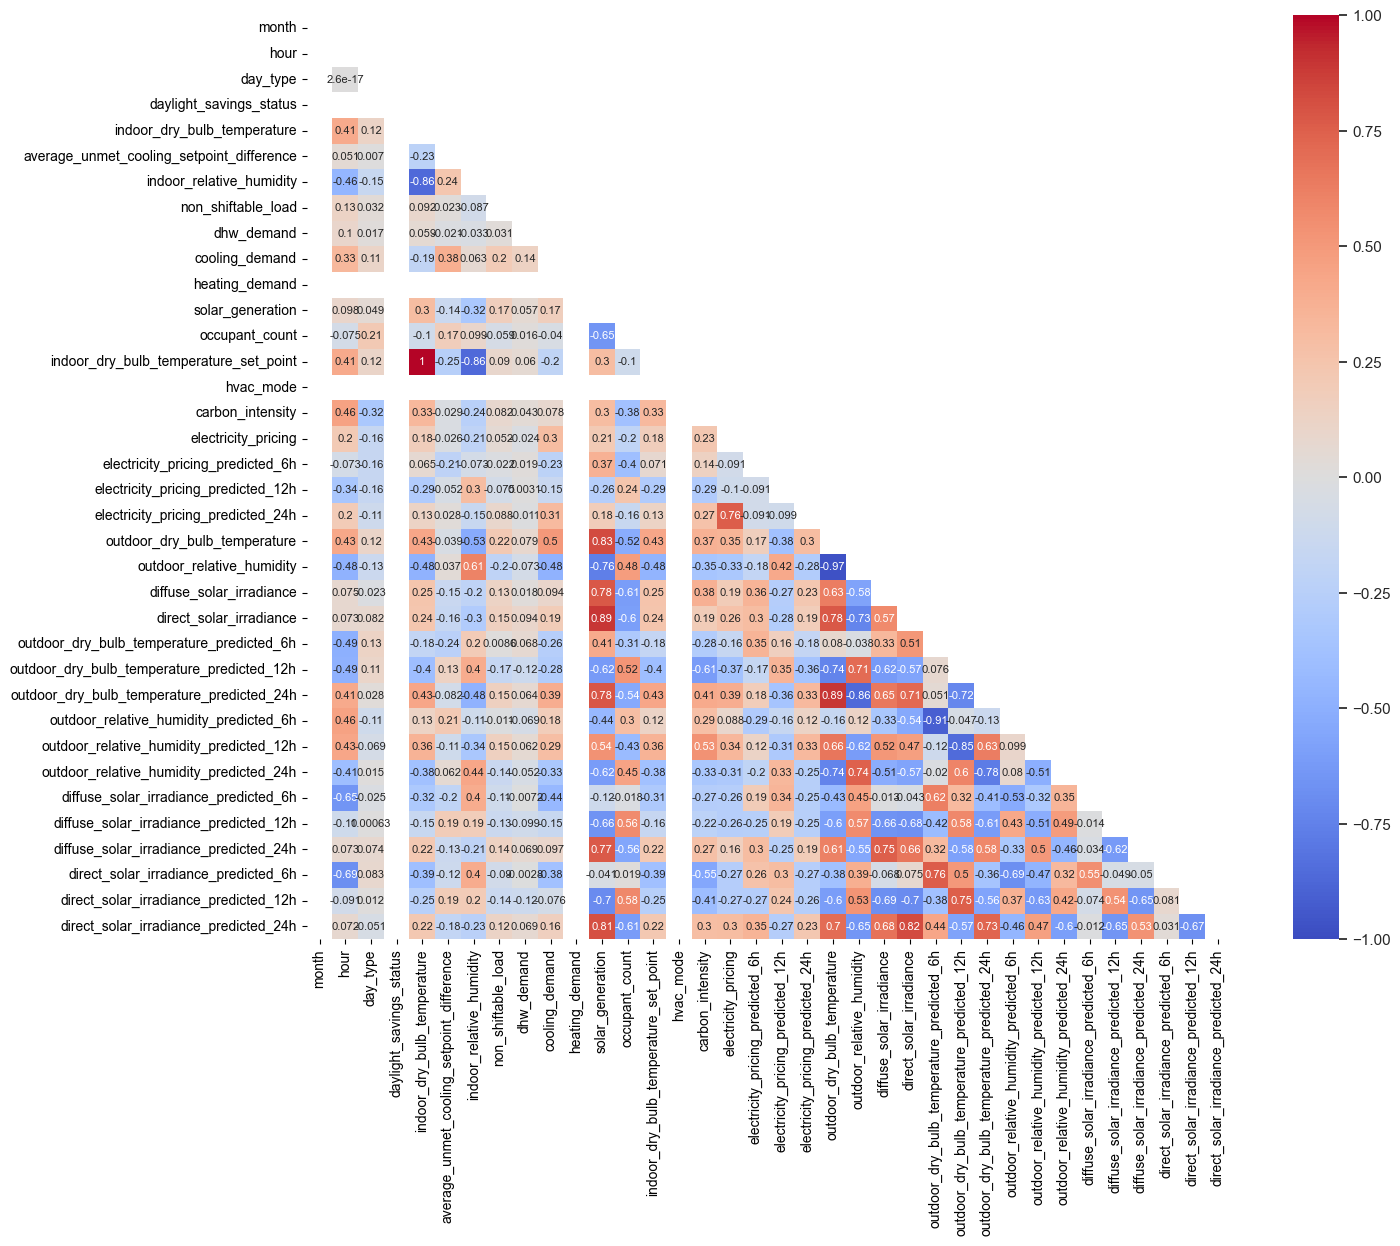

In [14]:
# Correlation matrix
corrmat = df.corr()

# Generate a mask for the upper triangle
matrix = np.triu(corrmat)
f, ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale=1)
sns.heatmap(corrmat, vmin=-1, vmax=1, center= 0, square=True, annot=True, annot_kws={'size': 8}, mask=matrix, fmt='.2g', cmap= 'coolwarm')

plt.show()

Ora seguiranno in ordine le predizioni relative a:

    1. cooling load
    2. dhw load
    3. non shiftable load

Predizione del cooling load

In [16]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dataset = df

x_scaled = scaler_x.fit_transform(dataset.drop(columns='cooling_demand'))
y_scaled = scaler_y.fit_transform(dataset[['cooling_demand']])

In [17]:
time_steps = 24
X_sequences, y_sequences = create_sequences(x_scaled, y_scaled, time_steps)

In [18]:
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [19]:
inputs = Input(shape=(time_steps, X_train.shape[2]))

In [20]:
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[metrics.mae])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 35)    │     36,643 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 35)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 35)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 35)    │         70 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 128)   │      4,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 35)    │      4,515 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 35)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 35)    │         70 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24, 64)    │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 24, 1)     │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,275 (188.57 KB)

 Trainable params: 48,275 (188.57 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, epochs = 150, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1982 - mean_absolute_error: 0.3458 - val_loss: 0.0475 - val_mean_absolute_error: 0.1776
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515 - mean_absolute_error: 0.1806 - val_loss: 0.0232 - val_mean_absolute_error: 0.1237
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0384 - mean_absolute_error: 0.1544 - val_loss: 0.0237 - val_mean_absolute_error: 0.1275
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0350 - mean_absolute_error: 0.1497 - val_loss: 0.0214 - val_mean_absolute_error: 0.1189
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354 - mean_absolute_error: 0.1502 - val_loss: 0.0209 - val_mean_absolute_error: 0.1130
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0343 - mean_absolute_error: 0.1439 - val_loss: 0.0214 - val_mean_absolute_error: 0.1130
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0407 - mean_absolute_error: 0.1566 - v

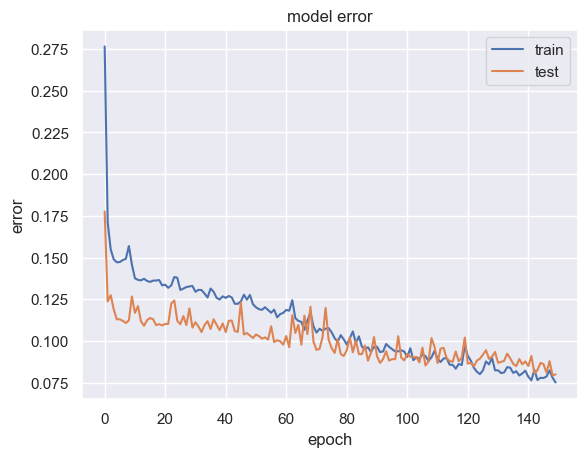

In [22]:
# Summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

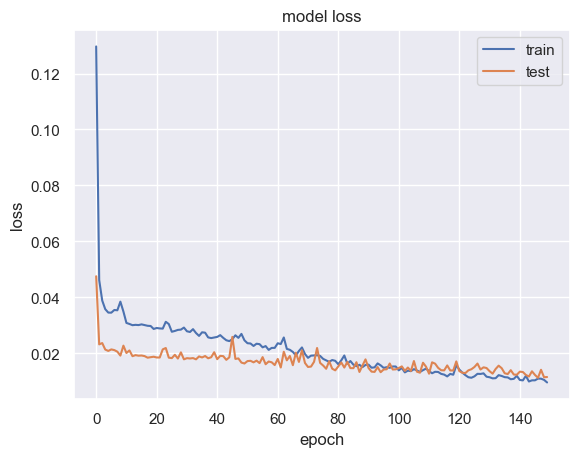

In [23]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [28]:
pred = model.predict(X_test)
pred = pred[:, -1, 0]

nrmse_cooling = NRMSE(y_test, pred)

print("nrmse: ", nrmse_cooling)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
nrmse:  0.12185133674795802


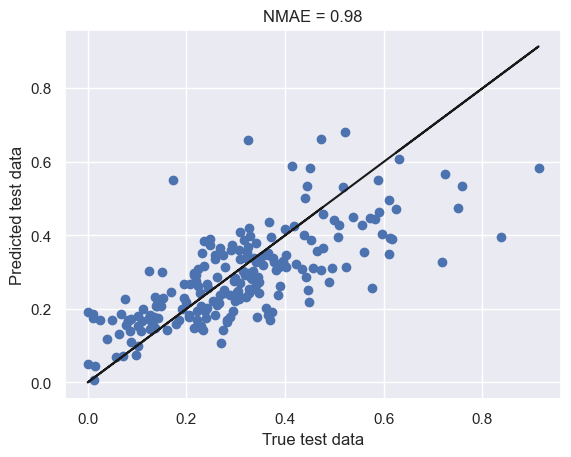

In [29]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

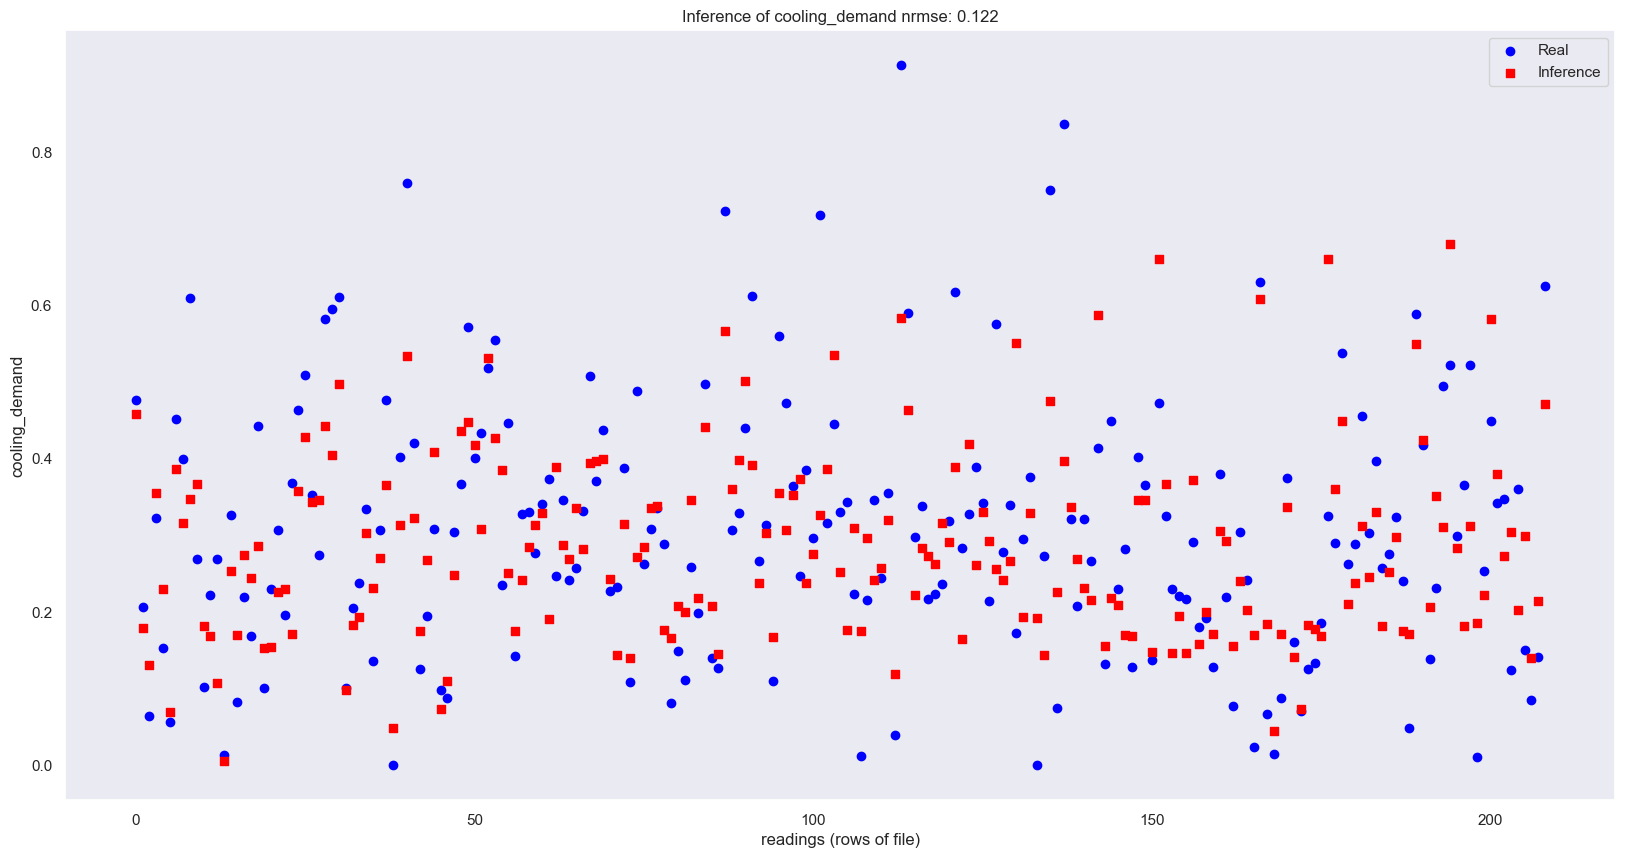

In [30]:
my_x=np.arange(0,len(X_test[:,0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of cooling_demand nrmse: {nrmse_cooling:.3f}')
plt.ylabel('cooling_demand')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

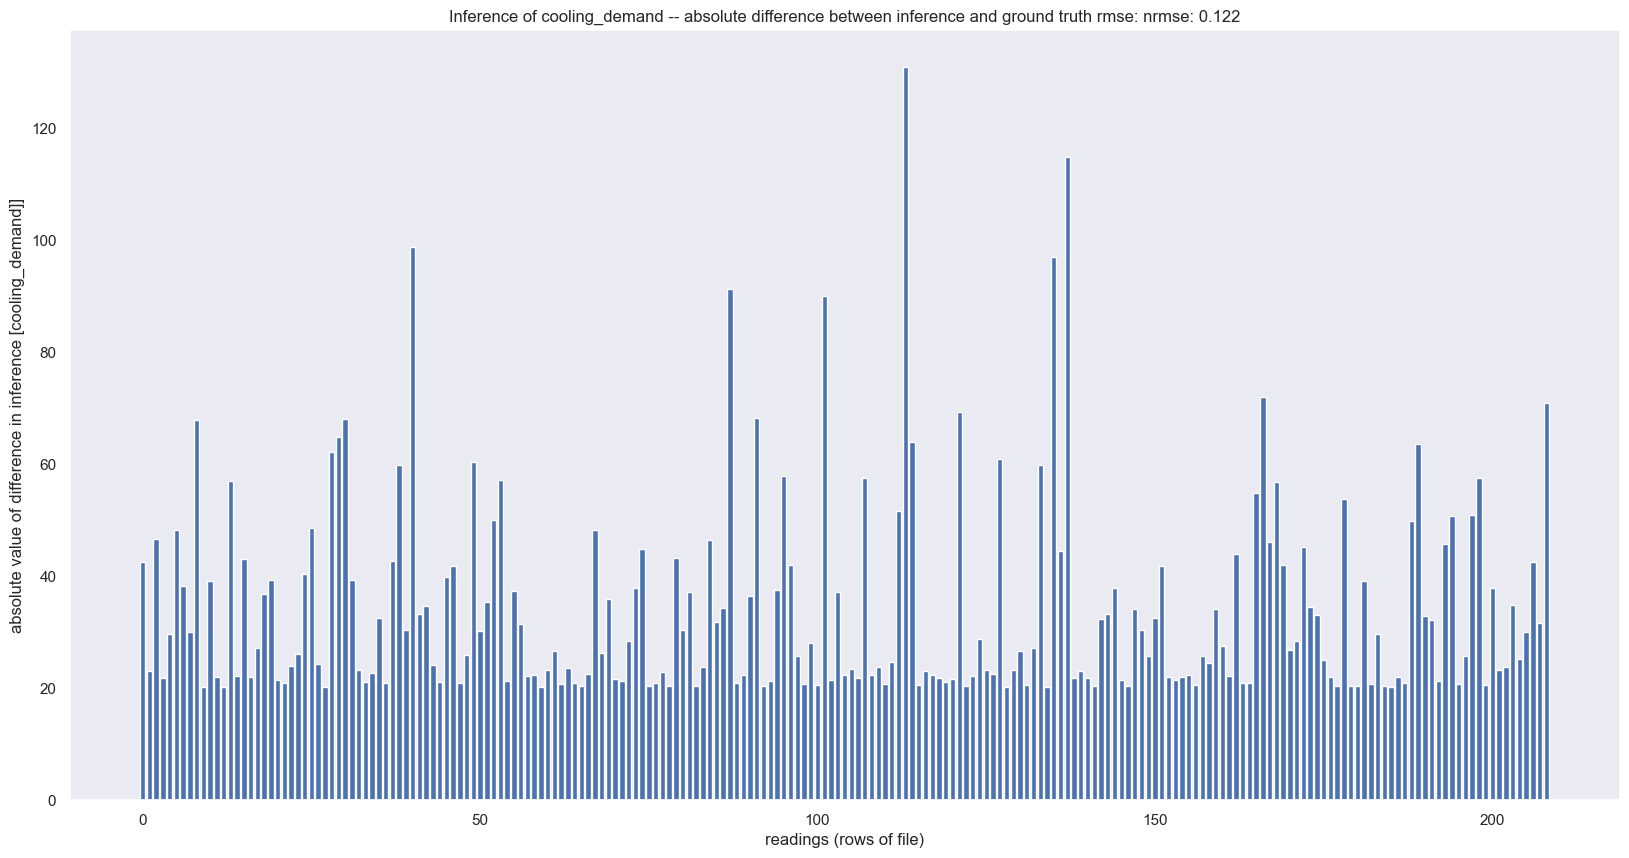

In [31]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)
my_d = np.sum(my_d, axis=1)

plt.bar(my_x,my_d)
plt.title(f'Inference of cooling_demand -- absolute difference between inference and ground truth rmse: nrmse: {nrmse_cooling:.3f}')
plt.ylabel(f'absolute value of difference in inference [cooling_demand]]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [32]:
w = 48

nrmse_single_cooling = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_cooling)

NRMSE per singola variabile con finestra temporale: 0.1316549137154934


Predizione del dhw load

In [33]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dataset = df

x_scaled = scaler_x.fit_transform(dataset.drop(columns='dhw_demand'))
y_scaled = scaler_y.fit_transform(dataset[['dhw_demand']])

In [34]:
time_steps = 24
X_sequences, y_sequences = create_sequences(x_scaled, y_scaled, time_steps)

In [35]:
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [36]:
inputs = Input(shape=(time_steps, X_train.shape[2]))

In [37]:
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[metrics.mae])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 35)    │     36,643 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 35)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 35)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 35)    │         70 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 24, 128)   │      4,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 24, 35)    │      4,515 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 35)    │          0 │ dense_5[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 35)    │         70 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24, 64)    │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 24, 1)     │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,275 (188.57 KB)

 Trainable params: 48,275 (188.57 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(X_train, y_train, epochs = 150, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.2036 - mean_absolute_error: 0.3335 - val_loss: 0.0242 - val_mean_absolute_error: 0.1216
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0304 - mean_absolute_error: 0.1330 - val_loss: 0.0182 - val_mean_absolute_error: 0.0894
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0229 - mean_absolute_error: 0.1047 - val_loss: 0.0176 - val_mean_absolute_error: 0.0814
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0166 - mean_absolute_error: 0.0921 - val_loss: 0.0150 - val_mean_absolute_error: 0.0876
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134 - mean_absolute_error: 0.0845 - val_loss: 0.0148 - val_mean_absolute_error: 0.0865
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0173 - mean_absolute_error: 0.0860 - val_loss: 0.0153 - val_mean_absolute_error: 0.0951
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0115 - mean_absolute_error: 0.0752 - v

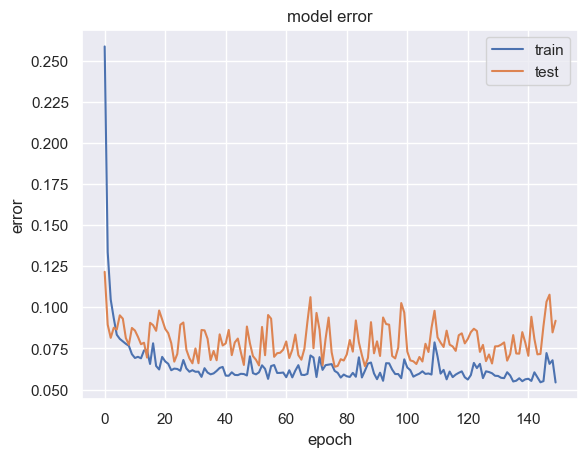

In [39]:
# Summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

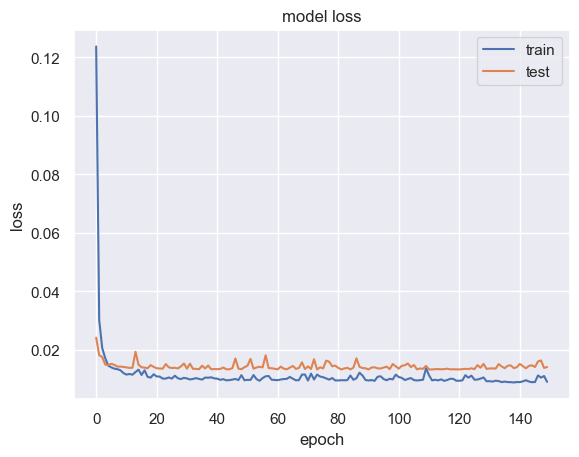

In [40]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [41]:
pred = model.predict(X_test)
pred = pred[:, -1, 0]

nrmse_dhw = NRMSE(y_test, pred)

print("nrmse : ",nrmse_dhw)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
nrmse :  0.13247908152862833


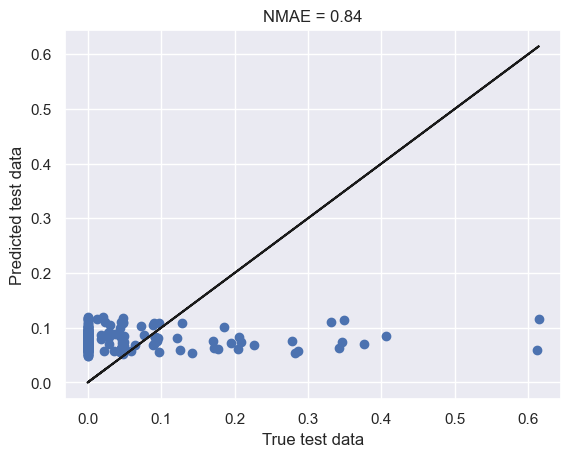

In [42]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

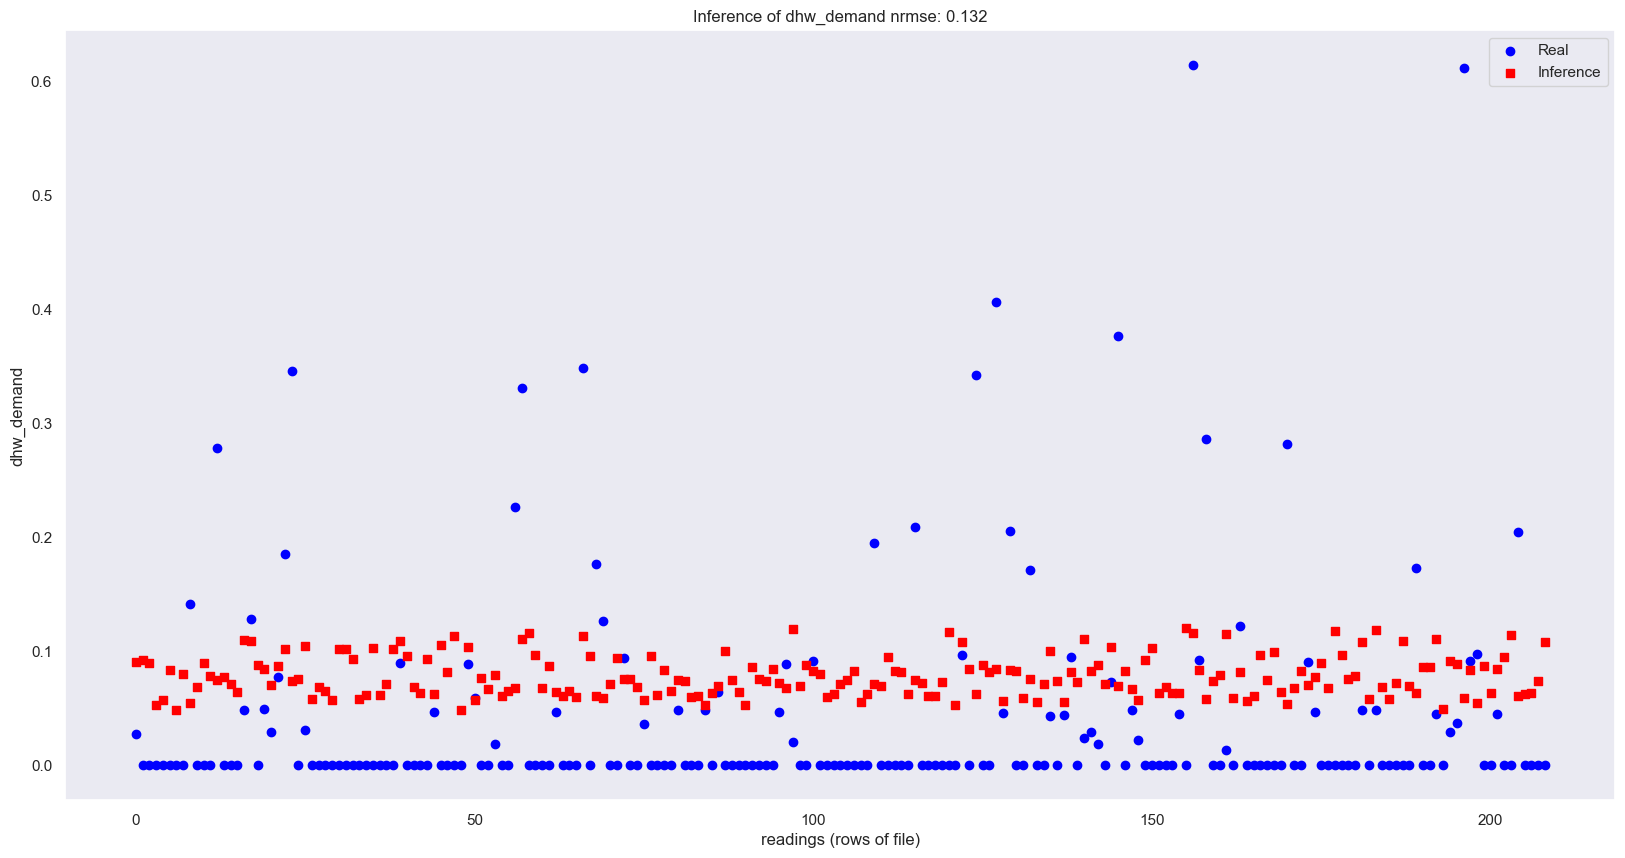

In [43]:
my_x=np.arange(0,len(X_test[:,0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of dhw_demand nrmse: {nrmse_dhw:.3f}')
plt.ylabel('dhw_demand')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

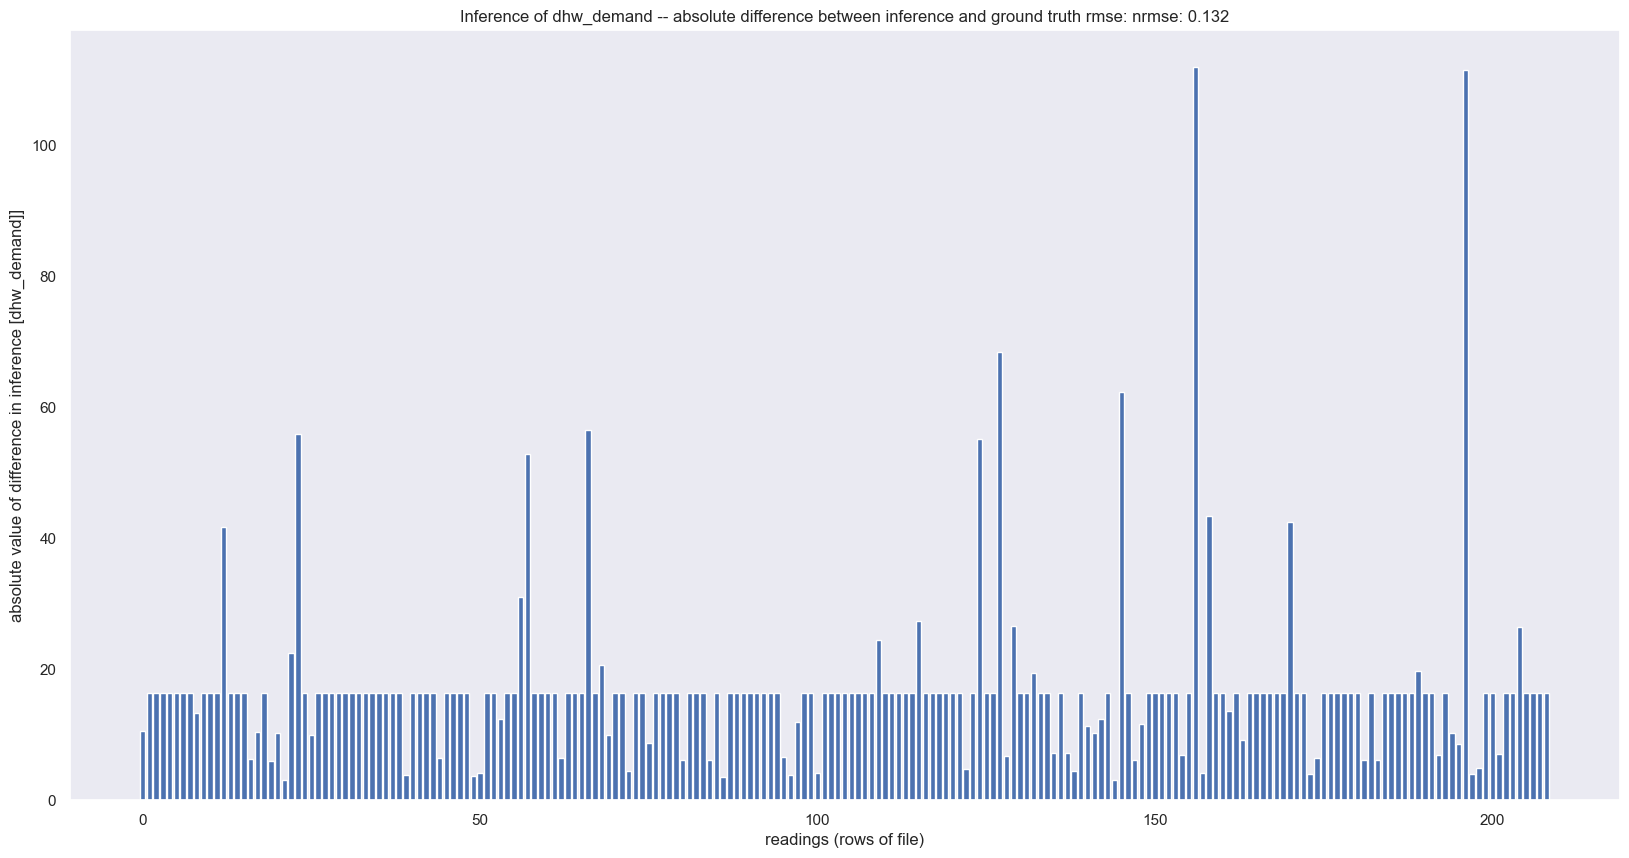

In [44]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)
my_d = np.sum(my_d, axis=1)

plt.bar(my_x,my_d)
plt.title(f'Inference of dhw_demand -- absolute difference between inference and ground truth rmse: nrmse: {nrmse_dhw:.3f}')
plt.ylabel(f'absolute value of difference in inference [dhw_demand]]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [45]:
w = 48

nrmse_single_dhw = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_dhw)

NRMSE per singola variabile con finestra temporale: 0.15339063452715032


Predizione del non shiftable load

In [46]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dataset = df

X_scaled = scaler_x.fit_transform(dataset.drop(columns='non_shiftable_load'))
y_scaled = scaler_y.fit_transform(dataset[['non_shiftable_load']])

In [47]:
time_steps = 24
X_sequences, y_sequences = create_sequences(x_scaled, y_scaled, time_steps)

In [48]:
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.25, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [49]:
inputs = Input(shape=(time_steps, X_train.shape[2]))

In [50]:
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[metrics.mae])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 35)    │     36,643 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 24, 35)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 35)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 35)    │         70 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 24, 128)   │      4,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 128)   │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 24, 35)    │      4,515 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 24, 35)    │          0 │ dense_9[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 35)    │         70 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 24, 64)    │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 24, 1)     │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,275 (188.57 KB)

 Trainable params: 48,275 (188.57 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(X_train, y_train, epochs = 150, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.2803 - mean_absolute_error: 0.4080 - val_loss: 0.0414 - val_mean_absolute_error: 0.1526
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0392 - mean_absolute_error: 0.1491 - val_loss: 0.0264 - val_mean_absolute_error: 0.0974
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0318 - mean_absolute_error: 0.1158 - val_loss: 0.0229 - val_mean_absolute_error: 0.0807
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0240 - mean_absolute_error: 0.0964 - val_loss: 0.0219 - val_mean_absolute_error: 0.0778
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0239 - mean_absolute_error: 0.0901 - val_loss: 0.0214 - val_mean_absolute_error: 0.0768
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0178 - mean_absolute_error: 0.0820 - val_loss: 0.0241 - val_mean_absolute_error: 0.0731
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0196 - mean_absolute_error: 0.0802 - v

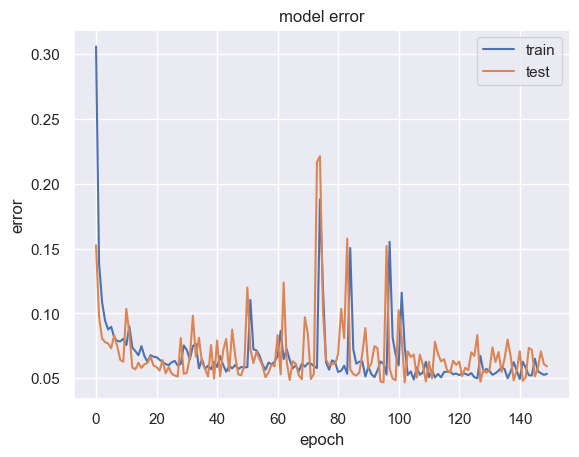

In [52]:
# Summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

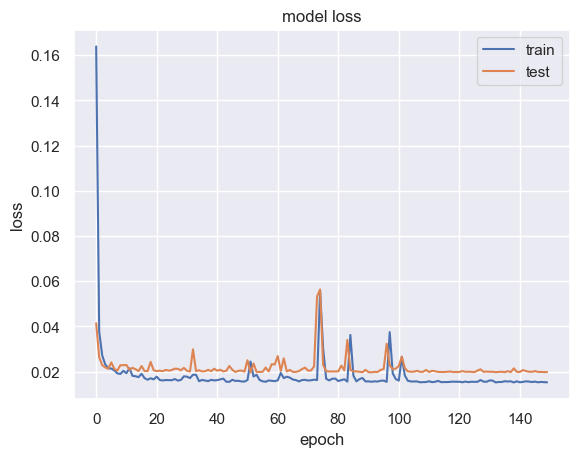

In [53]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [54]:
pred = model.predict(X_test)
pred = pred[:, -1, 0]

nrmse_nonshiftable = NRMSE(y_test, pred)

print("nrmse: ", nrmse_nonshiftable)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
nrmse:  0.0901344399820226


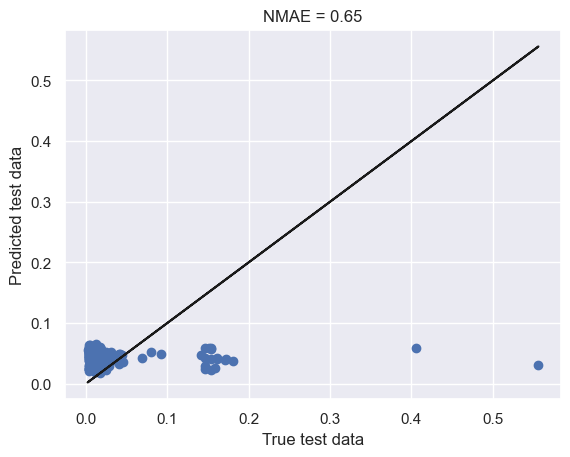

In [55]:
plt.scatter(y_test, pred)
plt.title(r"NMAE = %.2f" % (np.abs(y_test - pred).mean()/y_test.std()))
plt.plot(y_test, y_test, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

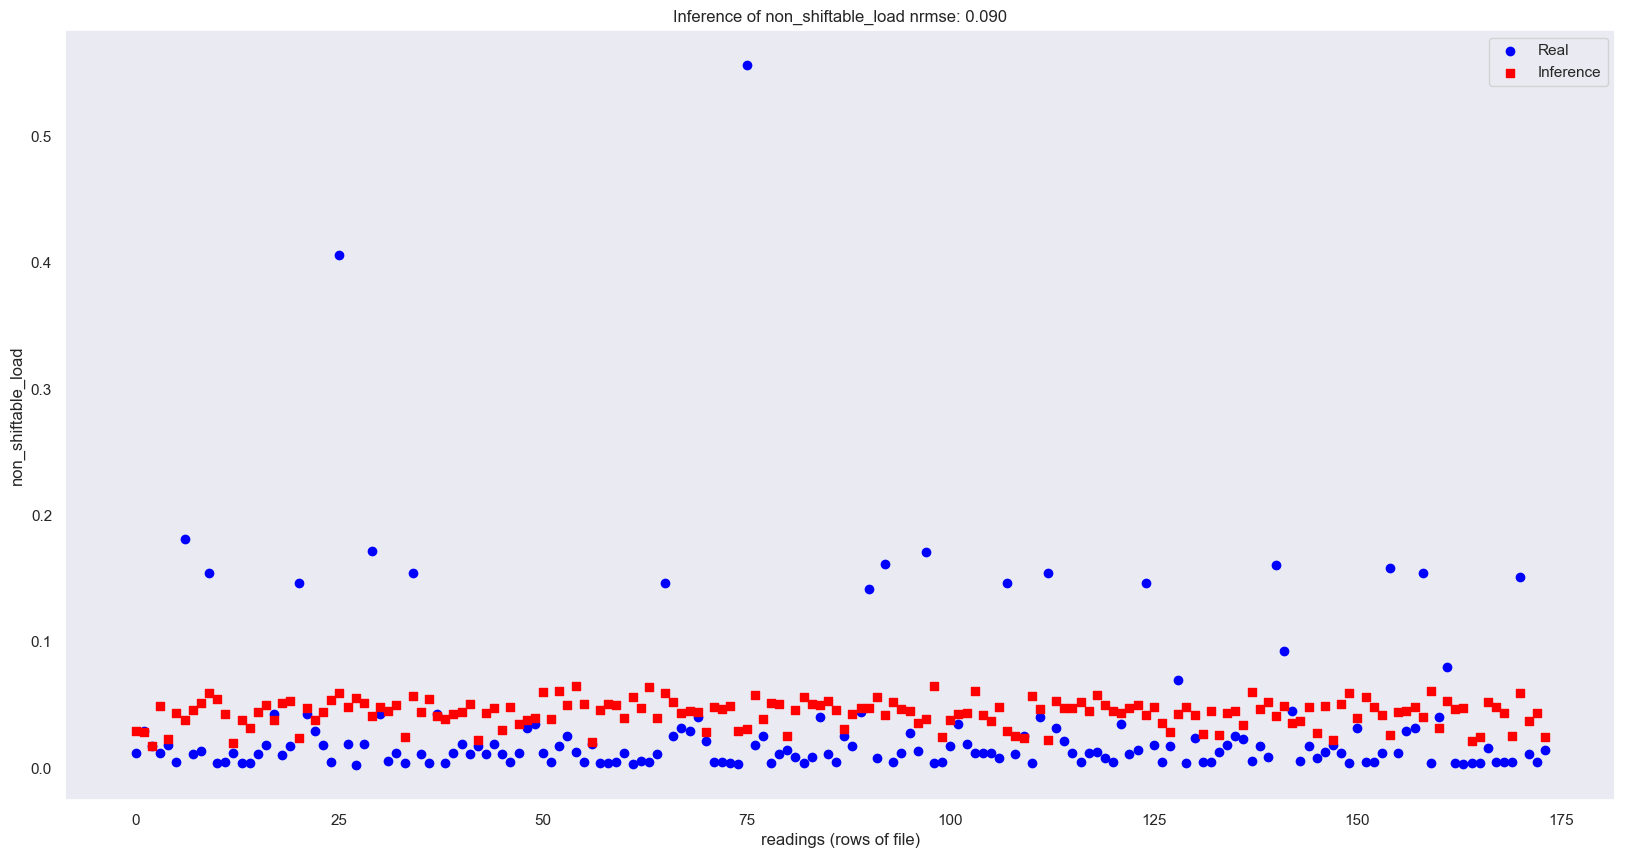

In [57]:
my_x=np.arange(0,len(X_test[:,0]),1)

fig = plt.figure(figsize=(20,10))
plt.scatter(my_x, y_test, label='Real', color='blue', marker='o')
plt.scatter(my_x, pred, label='Inference', color='red', marker='s')
plt.title(f'Inference of non_shiftable_load nrmse: {nrmse_nonshiftable:.3f}')
plt.ylabel('non_shiftable_load')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.legend()
plt.show()

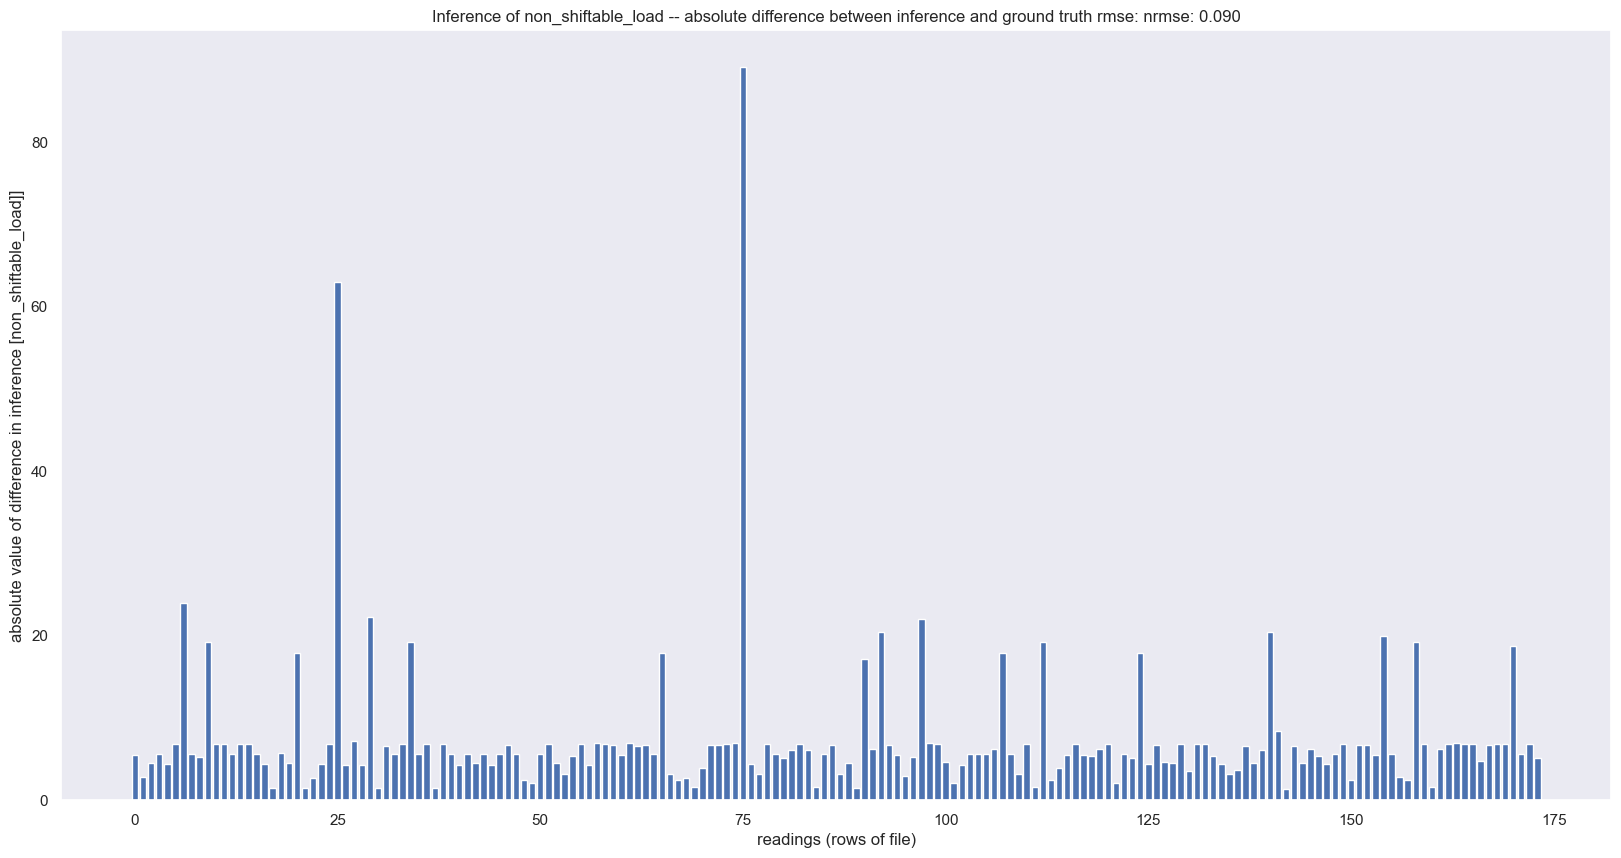

In [58]:
fig = plt.figure(figsize=(20,10))
my_d = abs(y_test-pred)
my_d = np.sum(my_d, axis=1)

plt.bar(my_x,my_d)
plt.title(f'Inference of non_shiftable_load -- absolute difference between inference and ground truth rmse: nrmse: {nrmse_nonshiftable:.3f}')
plt.ylabel(f'absolute value of difference in inference [non_shiftable_load]]')
plt.xlabel('readings (rows of file)')
plt.grid()
plt.show()

In [59]:
w = 48

nrmse_single_non_shiftable = NRMSE_window_single_variable(y_test, pred, w)
print("NRMSE per singola variabile con finestra temporale:", nrmse_single_non_shiftable)

NRMSE per singola variabile con finestra temporale: 0.11673127944665752


In [60]:
#non riuscendo a capire molto dalla sola formula ho provato a "tradurre" la definizione e ho dato due soluzioni

#questo ScoreForecast è dato dalla somma di tutte le NRMSE calcolate precedentemente e divise per il numero totale di variabili
ScoreForecast = (nrmse_nonshiftable + nrmse_cooling + nrmse_dhw) / 3
print(f"La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: {ScoreForecast:.3f}.")

La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: 0.115.


In [61]:
#questo invece è dato dalla somma di tutte le NRMSE tenendo conto di una finestra temporale (48h), e si dovrebbe avvicinare alla formula
ScoreForecast = (nrmse_single_non_shiftable + nrmse_single_cooling + nrmse_single_dhw) / 3
print(f"La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: {ScoreForecast:.3f}.")

La media, su tutte le variabili previste, dell'errore quadratico medio normalizzato (NRMSE) delle previsioni effettuate: 0.134.
